## Set-up

In [ ]:
# Environment setup
from google.colab import drive
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import GridSearchCV, train_test_split
!pip3 install scikeras
import scikeras
from scikeras.wrappers import KerasClassifier
import keras
from keras.utils import load_img, img_to_array
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
import tensorflow as tf
from keras.metrics import Precision, CategoricalAccuracy, Recall
!pip3 install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetV2L, DenseNet201, ResNet152V2, MobileNetV2, InceptionResNetV2, ConvNeXtLarge
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Num GPUs Available:  1


In [ ]:
# Load the data from GoogleDrive (this will need to be updated with your own GoogleDrive link)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load and Preprocess

In [ ]:
# Create a directory of the images
image_dir = '/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CUB_200_2011/images'

# Create the labels from file names
image_filenames = os.listdir(image_dir)

# Create pandas dataframe of test_train_split.txt
train_test_split = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CUB_200_2011/train_test_split.txt', sep=" ", header=None)

# Create padas dataframe of images.text
image_text = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CUB_200_2011/images.txt', sep=" ", header=None)

image_labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CUB_200_2011/image_class_labels.txt', sep=" ", header=None)

In [ ]:
print(train_test_split)

           0  1
0          1  0
1          2  1
2          3  0
3          4  1
4          5  1
...      ... ..
11783  11784  1
11784  11785  0
11785  11786  0
11786  11787  1
11787  11788  0

[11788 rows x 2 columns]


In [ ]:
print(image_text)

           0                                                  1
0          1  001.Black_footed_Albatross/Black_Footed_Albatr...
1          2  001.Black_footed_Albatross/Black_Footed_Albatr...
2          3  001.Black_footed_Albatross/Black_Footed_Albatr...
3          4  001.Black_footed_Albatross/Black_Footed_Albatr...
4          5  001.Black_footed_Albatross/Black_Footed_Albatr...
...      ...                                                ...
11783  11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784  11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785  11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786  11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787  11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]


In [ ]:
print(image_labels)

           0    1
0          1    1
1          2    1
2          3    1
3          4    1
4          5    1
...      ...  ...
11783  11784  200
11784  11785  200
11785  11786  200
11786  11787  200
11787  11788  200

[11788 rows x 2 columns]


In [ ]:
# Join image_text and train_test_split
train_test_split.columns = ['0', 'split']
image_text.columns = ['0', 'image']
image_labels.columns = ['0', 'label']
image_labels['label'] = image_labels['label'].values.astype(str)
split = pd.merge(train_test_split, image_text, how='inner', on='0')
split_images = pd.merge(split, image_labels, how='inner', on='0')

In [ ]:
print(split_images)

           0  split                                              image  label
0          1      0  001.Black_footed_Albatross/Black_Footed_Albatr...      1
1          2      1  001.Black_footed_Albatross/Black_Footed_Albatr...      1
2          3      0  001.Black_footed_Albatross/Black_Footed_Albatr...      1
3          4      1  001.Black_footed_Albatross/Black_Footed_Albatr...      1
4          5      1  001.Black_footed_Albatross/Black_Footed_Albatr...      1
...      ...    ...                                                ...    ...
11783  11784      1  200.Common_Yellowthroat/Common_Yellowthroat_00...    200
11784  11785      0  200.Common_Yellowthroat/Common_Yellowthroat_00...    200
11785  11786      0  200.Common_Yellowthroat/Common_Yellowthroat_00...    200
11786  11787      1  200.Common_Yellowthroat/Common_Yellowthroat_00...    200
11787  11788      0  200.Common_Yellowthroat/Common_Yellowthroat_00...    200

[11788 rows x 4 columns]


In [ ]:
# Create test and train split, shuffling train for validation set
train_split = split_images[split_images['split'] == 1]
train_df = train_split.sample(frac = 1)
test_df = split_images[split_images['split'] == 0]

In [ ]:
print(train_df)

           0  split                                              image  label
357      358      1  007.Parakeet_Auklet/Parakeet_Auklet_0001_79597...      7
6839    6840      1  117.Clay_colored_Sparrow/Clay_Colored_Sparrow_...    117
3332    3333      1  058.Pigeon_Guillemot/Pigeon_Guillemot_0014_400...     58
10165  10166      1  173.Orange_crowned_Warbler/Orange_Crowned_Warb...    173
2226    2227      1  039.Least_Flycatcher/Least_Flycatcher_0099_302...     39
...      ...    ...                                                ...    ...
127      128      1  003.Sooty_Albatross/Sooty_Albatross_0063_1101.jpg      3
4494    4495      1     078.Gray_Kingbird/Gray_Kingbird_0022_70155.jpg     78
4806    4807      1  083.White_breasted_Kingfisher/White_Breasted_K...     83
2561    2562      1  045.Northern_Fulmar/Northern_Fulmar_0070_43916...     45
665      666      1               013.Bobolink/Bobolink_0102_10807.jpg     13

[5994 rows x 4 columns]


In [ ]:
# Rescale images to values from 0 to 1
datagen=ImageDataGenerator(rescale=1./255., validation_split=0.1)

In [ ]:
# Create train, val and test datasets
train = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=123,
    subset='training')

val = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=123,
    subset='validation')

test = datagen.flow_from_dataframe(
    dataframe=test_df, # This was train_df and contaiminated the data.
    directory=image_dir,
    x_col='image',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

#Preferred sizes:
#MobileNetV2 = 224, 224, 3
#ResNet15V2 = 224, 224, 3
#DenseNet201 = 224, 224, 3
#InceptionResNetV2 = 299, 299, 3
#EfficientNetV2L = EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0-255] range
#ConvNeXtLarge = ConvNeXt models expect their inputs to be float or uint8 tensors of pixels with values in the [0-255] range.

Found 5395 validated image filenames belonging to 200 classes.
Found 599 validated image filenames belonging to 200 classes.
Found 5994 validated image filenames belonging to 200 classes.


In [ ]:
# Print shape of x and y
for x, y in train:
  print(x.shape)
  print(y.shape)
  break

(32, 224, 224, 3)
(32, 200)


## Modelling

In [ ]:
# Parameters
input_shape = (224, 224, 3)
num_classes = 200

In [ ]:
# These networks are supported:
network_names = [ 'mobilenetv2', 'densenet201', 'resnet152v2', 'inceptionresnetv2', 'efficientnetv2L', 'convnextlarge']

print("The following network architectures are available: ", network_names)

####################################
# The network id is selected here: #
network_id = 1
####################################

selected_network = network_names[network_id]
print(f"Selected network: {selected_network}")

The following network architectures are available:  ['mobilenetv2', 'densenet201', 'resnet152v2', 'inceptionresnetv2', 'efficientnetv2L', 'convnextlarge']
Selected network: densenet201


In [ ]:
# This function defines our classification network: ##UPDATE
def create_model(selected_network):

  # The model is selected amongst the supported architectures:
  model_name = {
    'mobilenetv2'       : MobileNetV2,
    'densenet201'       : DenseNet201,
    'resnet152v2'       : ResNet152V2,
    'inceptionresnetv2' : InceptionResNetV2,
    'efficientnetv2L'   : EfficientNetV2L,
    'convnextlarge'     : ConvNeXtLarge
  }[selected_network]

  # Create base model
  base_model = model_name(input_shape=input_shape, weights='imagenet', include_top=False)
  # Freeze base model
  base_model.trainable = False

  # Create new model on top
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  output = keras.layers.Dense(200, activation='softmax')(x)
  model = keras.models.Model(inputs=[base_model.input], outputs=[output])

  adam = Adam()

  # The model optimises cross entropy as its loss function and will monitor classification accuracy:
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[CategoricalAccuracy(), Precision(), Recall(), F1Score(num_classes=200)])

  # Printing model summary:
  print(model.summary())

  return model

print('Done!')

Done!


In [ ]:
# Create model
model = create_model(selected_network)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_10[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

In [ ]:
# Define learning rate scheduler
def learning_rate_schedule(epoch):
    """Learning rate schedule function."""
    learning_rate = 1e-3
    if epoch > 10:
        learning_rate *= 0.1
    elif epoch > 5:
        learning_rate *= 0.5
    return learning_rate

In [ ]:
# Set up callback in keras to stop the training when the performance on the validation set stops improving
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/checkpoints/DenseNet201_2', monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

lr_scheduler = keras.callbacks.LearningRateScheduler(learning_rate_schedule)

In [ ]:
history = model.fit(train, epochs=50, callbacks=[early_stop, reduce, checkpoint], batch_size = 32, validation_data=(val))
print('Done!')

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 0.2011 - categorical_accuracy: 0.9931 - precision_9: 0.9992 - recall_9: 0.9475 - f1_score: 0.9931
Epoch 1: val_categorical_accuracy improved from -inf to 0.60601, saving model to /content/gdrive/MyDrive/Colab Notebooks/CSC8637/checkpoints/DenseNet201_2


169/169 [==============================] - 118s 704ms/step - loss: 0.2011 - categorical_accuracy: 0.9931 - precision_9: 0.9992 - recall_9: 0.9475 - f1_score: 0.9931 - val_loss: 1.5338 - val_categorical_accuracy: 0.6060 - val_precision_9: 0.8100 - val_recall_9: 0.4341 - val_f1_score: 0.5584 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 0.1411 - categorical_accuracy: 0.9978 - precision_9: 0.9994 - recall_9: 0.9776 - f1_score: 0.9978
Epoch 2: val_categorical_accuracy did not improve from 0.60601
169/169 [==============================] - 37s 220ms/step - loss: 0.1411 - categorical_accuracy: 0.9978 - precision_9: 0.9994 - recall_9: 0.9776 - f1_score: 0.9978 - val_loss: 1.5266 - val_categorical_accuracy: 0.6010 - val_precision_9: 0.7890 - val_recall_9: 0.4558 - val_f1_score: 0.5696 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 0.1028 - categorical_accuracy: 0.9994 - precision_9: 1.0000 - recall_9: 0.9911 - f1_score: 0

169/169 [==============================] - 133s 792ms/step - loss: 0.1028 - categorical_accuracy: 0.9994 - precision_9: 1.0000 - recall_9: 0.9911 - f1_score: 0.9994 - val_loss: 1.5227 - val_categorical_accuracy: 0.6177 - val_precision_9: 0.7955 - val_recall_9: 0.4674 - val_f1_score: 0.5812 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 0.0810 - categorical_accuracy: 0.9996 - precision_9: 1.0000 - recall_9: 0.9968 - f1_score: 0.9996
Epoch 4: val_categorical_accuracy improved from 0.61770 to 0.61937, saving model to /content/gdrive/MyDrive/Colab Notebooks/CSC8637/checkpoints/DenseNet201_2


169/169 [==============================] - 118s 702ms/step - loss: 0.0810 - categorical_accuracy: 0.9996 - precision_9: 1.0000 - recall_9: 0.9968 - f1_score: 0.9996 - val_loss: 1.4914 - val_categorical_accuracy: 0.6194 - val_precision_9: 0.7961 - val_recall_9: 0.4825 - val_f1_score: 0.5827 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - ETA: 0s - loss: 0.0653 - categorical_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 0.9993 - f1_score: 1.0000
Epoch 5: val_categorical_accuracy did not improve from 0.61937
169/169 [==============================] - 38s 222ms/step - loss: 0.0653 - categorical_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 0.9993 - f1_score: 1.0000 - val_loss: 1.4790 - val_categorical_accuracy: 0.6093 - val_precision_9: 0.8027 - val_recall_9: 0.4958 - val_f1_score: 0.5699 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - ETA: 0s - loss: 0.0549 - categorical_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 0.9996 - f1_score: 1

169/169 [==============================] - 118s 702ms/step - loss: 0.0433 - categorical_accuracy: 0.9998 - precision_9: 1.0000 - recall_9: 0.9998 - f1_score: 0.9998 - val_loss: 1.4654 - val_categorical_accuracy: 0.6277 - val_precision_9: 0.7933 - val_recall_9: 0.5125 - val_f1_score: 0.5863 - lr: 5.0000e-04
Epoch 8/50
169/169 [==============================] - ETA: 0s - loss: 0.0400 - categorical_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - f1_score: 1.0000
Epoch 8: val_categorical_accuracy did not improve from 0.62771
169/169 [==============================] - 38s 224ms/step - loss: 0.0400 - categorical_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - f1_score: 1.0000 - val_loss: 1.4651 - val_categorical_accuracy: 0.6144 - val_precision_9: 0.8031 - val_recall_9: 0.5109 - val_f1_score: 0.5693 - lr: 5.0000e-04
Epoch 9/50
169/169 [==============================] - ETA: 0s - loss: 0.0376 - categorical_accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - f1_

## Evaluation

1/1 [==============================] - 4s 4s/step


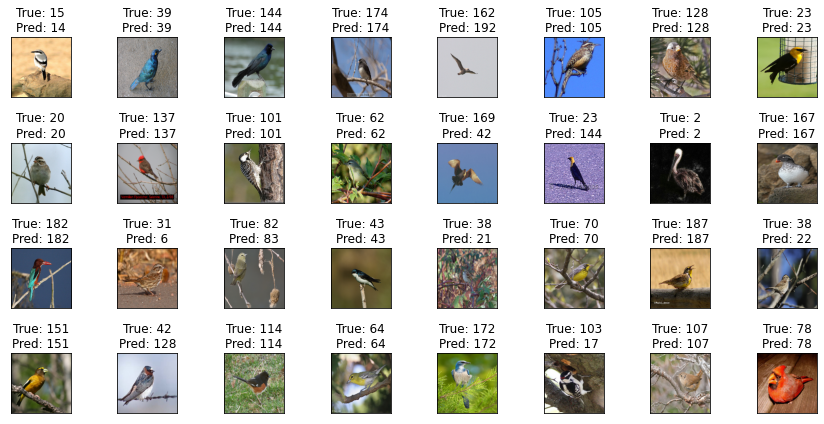

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images and labels
test_images, test_labels = test.next()

# Get the predicted class probabilities for the images
predicted = model.predict(test_images)

# Get the predicted class labels for the images
predicted_labels = np.argmax(predicted, axis=-1)

# Plot the images with their true and predicted labels
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.set_title(f'True: {np.argmax(test_labels[i])}\nPred: {predicted_labels[i]}')

plt.tight_layout()
plt.show()

In [ ]:
# Print out model scores
_, acc, prec, rec, f1 = model.evaluate(test, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))
print('Precision: %.3f' % (prec * 100.0))
print('Recall: %.3f' % (rec * 100.0))

188/188 [==============================] - 44s 234ms/step - loss: 0.5943 - categorical_accuracy: 0.8824 - precision_7: 0.9680 - recall_7: 0.7324 - f1_score: 0.8838
Accuracy: 88.238
Precision: 96.803
Recall: 73.240


In [ ]:
# Save model
!pip install pyyaml h5py  # Required to save models in HDF5 format
model.save('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/models/DenseNet201_2.h5')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Predict values with test dataset
prediction = model.predict(test)

# Get the true labels
test_labels = test.classes

# Get the predicted labels by selecting the class with the highest probability
prediction_labels = np.argmax(prediction, axis=1)

188/188 [==============================] - 48s 235ms/step


In [ ]:
# Create confusion matrix
matrix = confusion_matrix(test_labels, prediction_labels)
print(matrix)

[[28  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0 23  0]
 [ 0  0  0 ...  0  0 22]]


Text(0.5, 15.0, 'Predicted Values')

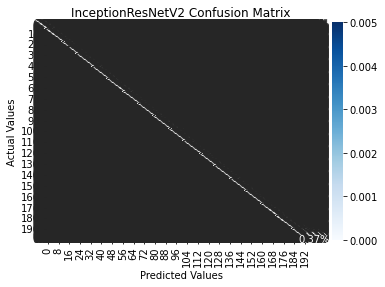

In [ ]:
# Plot the matrix
map = sns.heatmap(matrix/np.sum(matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.title('InceptionResNetV2 Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')


## New Images

In [ ]:
# Define the input shape
input_shape = (224, 224, 3)

#Preferred sizes:
#MobileNetV2 = 224, 224, 3
#ResNet15V2 = 224, 224, 3
#DenseNet201 = 224, 224, 3
#InceptionResNetV2 = 299, 299, 3
#EfficientNetV2L = EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0-255] range
#ConvNeXtLarge = ConvNeXt models expect their inputs to be float or uint8 tensors of pixels with values in the [0-255] range.

# Load an image and preprocess it for prediction
image_path = '/content/gdrive/MyDrive/Colab Notebooks/CSC8637/CSC8637 testing/Task2_bird_4.jpg'
image = load_img(image_path, target_size=input_shape)
input_arr = img_to_array(image)
input_arr = np.array([input_arr])


1/1 [==============================] - 4s 4s/step


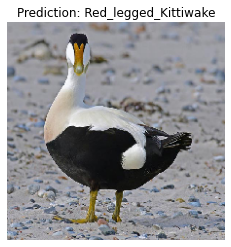

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/CSC8637/models/DenseNet201.h5')

# Make a prediction on the image
prediction = model.predict(input_arr)

# Get the predicted class labels for the images
predicted_label = np.argmax(prediction, axis=-1)

# Map bird labels to bird name
label_name_map = {}

for name in image_filenames:
  label, name = name.split(".")
  label_name_map[int(label)] = name

# Visualize the prediction
plt.imshow(image)
plt.title(f"Prediction: {label_name_map[predicted_label[0]]}")
plt.axis('off')
plt.show()